# Training functions

In [3]:
%matplotlib inline

import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import os
import time
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
from google.colab import output
output.enable_custom_widget_manager()


class aux_bot():

    def __init__(self,drive_path = None, data_path = None, train_forward = False, train_inverse = False, normalize=True, train_comp=True):
        # Setup device
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print("Connected: ", self.device)
        self.data_path = data_path
        self.drive_path = drive_path
        self.model_path = None
        self.normalize = normalize

        # Parameter indicies
        m_inputs = 5
        self.motor_slice = slice(0,m_inputs)
        self.end_slice = slice(m_inputs,m_inputs+7)
        self.input_size = self.motor_slice.stop - self.motor_slice.start
        self.output_size = self.end_slice.stop - self.end_slice.start

        # Constant for forward model
        BATCH_SIZE = 16
        EPOCHS = 50
        LEARNING_RATE = 0.0005
        MOMENTUM = 0.9
        WEIGHT_DECAY = 0

        self.upload_data(drive_path+data_path,batch_size = BATCH_SIZE)

        # Train forward model
        if  train_forward:
            self.fk_net = self.forward_net(hidden=1024,inputs=self.input_size,outputs=self.output_size)
            self.train_forward(self.fk_net,EPOCHS,LEARNING_RATE,MOMENTUM,WEIGHT_DECAY,annealing=True)
            self.eval_model_forward(self.fk_net,self.fk_train_loss,invert_zy = True)

        # Load forward model instead
        if not train_forward:
            self.fk_net = self.forward_net(hidden=1024)
            self.fk_net.load_state_dict(torch.load(drive_path + '/models/forward_2023_07_20-19_39_11_11.447mm'))
            self.fk_net.eval()
            print("[aux_net] Forward model succesfully loaded")

        # Constant for inverse model
        EPOCHS = 50
        LEARNING_RATE = 0.0005
        MOMENTUM = 0.9

        # Train inverse model
        if  train_inverse:
            self.ik_net = self.inverse_net(hidden=1600,inputs=self.output_size,outputs=self.input_size)
            self.train_inverse(self.ik_net,EPOCHS,LEARNING_RATE,MOMENTUM,WEIGHT_DECAY,annealing=True)
            self.eval_model_inverse(self.ik_net,self.ik_train_loss,invert_zy = True)

        # Load forward model instead
        if not train_inverse:
            self.inverse_model = self.inverse_net(hidden=1600)
            self.inverse_model.load_state_dict(torch.load(drive_path + '/models/inverse_2023_07_26-18_22_29_6.124pwm'))
            self.inverse_model.eval()
            self.inverse_model.to(self.device)
            print("[aux_net] Inverse model succesfully loaded")

        EPOCHS = 50
        BATCH_SIZE = 8
        LEARNING_RATE = 0.0005
        MOMENTUM = 0.9

    # Apply data normalization
    def normalize_data(self,data,d_type="full"):
        if d_type == "full":
            data = (data-self.min_scale)/(self.max_scale-self.min_scale)
        elif d_type == "motor":
                data = (data-self.min_scale[self.motor_slice])/(self.max_scale[self.motor_slice]-self.min_scale[self.motor_slice])
        elif d_type == "end_full":
            data = (data-self.min_scale[self.end_slice])/(self.max_scale[self.end_slice]-self.min_scale[self.end_slice])
        return data

    # Return data to original units
    def denormalize_data(self,data,d_type="full"):
        if d_type == "full":
            data = data*(self.max_scale-self.min_scale)+self.min_scale
        elif d_type == "motor":
                data = data*(self.max_scale[self.motor_slice]-self.min_scale[self.motor_slice])+self.min_scale[self.motor_slice]
        elif d_type == "end_full":
            data = data*(self.max_scale[self.end_slice]-self.min_scale[self.end_slice])+self.min_scale[self.end_slice]
        return data

    # Uploads training dat
    def upload_data(self,data_path, trim_length = None,batch_size=1):
        '''
        Inputs in data are motor positions [dtm_13, dtm_24, de_13, de_24, d_l]
        Out positions [x_top (0), y_top (1), z_top (2), qx_top (3), qy_top (4), qz_top (5), qw_top (6)]
        '''
        self.data = np.loadtxt(data_path, skiprows = 1, delimiter=',',dtype = 'float32',usecols = tuple(range(2,2+self.input_size+self.output_size)))


        print("Inputs: ",self.data[0:3,self.motor_slice,])
        print("Outputs: ",self.data[0:3,self.end_slice,])

        self.min_scale = np.amin(self.data,0)
        self.max_scale = np.amax(self.data,0)

        self.raw_data = np.copy(self.data)
        if self.normalize: self.data = self.normalize_data(self.data)

        # Split into randomized 80/20 train test
        np.random.seed(8)
        np.random.shuffle(self.data)
        n = np.size(self.data,0)
        self.norm_data = np.copy(self.data)
        self.train_set = self.data[0:int(n*.8),:]
        self.test_set = self.data[int(n*.8):n,:]

        # Set up data loader
        self.train_loader = torch.utils.data.DataLoader(self.train_set, batch_size = batch_size)
        self.test_loader = torch.utils.data.DataLoader(self.test_set, batch_size = batch_size)
        self.data = {'train': self.train_loader, 'test': self.test_loader, 'train_set' : self.train_set, 'test_set' : self.test_set}

    def upload_comp_data(self,batch_size=1):
        self.data_comp = np.loadtxt(self.drive_path+"/data/inverse_compensation_motor_data.csv",skiprows = 1,delimiter=',',dtype = 'float32')

        self.raw_data_comp = np.copy(self.data)

        self.data_comp[:,0:7] = self.normalize_data(self.data_comp[:,0:7],"end_full")
        self.data_comp[:,7:14] = self.normalize_data(self.data_comp[:,7:14],"end_full")
        self.data_comp[:,14:] = self.normalize_data(self.data_comp[:,14:],"motor")


        # Split into randomized 80/20 train test
        np.random.seed(8)
        np.random.shuffle(self.data_comp)
        n = np.size(self.data_comp,0)
        self.train_set_comp = self.data_comp[0:int(n*.8),:]
        self.test_set_comp = self.data_comp[int(n*.8):n,:]

        # Set up data loader
        self.train_loader_comp = torch.utils.data.DataLoader(self.train_set_comp, batch_size = batch_size)
        self.test_loader_comp = torch.utils.data.DataLoader(self.test_set_comp, batch_size = batch_size)
        self.data_comp = {'train': self.train_loader_comp, 'test': self.test_loader_comp, 'train_set' : self.train_set_comp, 'test_set' : self.test_set_comp}


    ########################
    # FORWARD NETWORK
    ########################
    class forward_net(nn.Module):
        def __init__(self, inputs=5, hidden=1024, outputs=7):
            super().__init__()
            self.fc1 = nn.Linear(inputs,hidden)
            self.fc2 = nn.Linear(hidden,hidden)
            self.fc3 = nn.Linear(hidden,outputs)
            self.input_size = inputs
            self.output_size = outputs

        def forward(self,x):
            x = torch.flatten(x, 1)
            x = self.fc1(x)
            x = F.relu(x)
            x = self.fc2(x)
            x = F.relu(x)
            x = self.fc3(x)
            return x

    def quaternion_angular_error(self,q1, q2):
        # Clipping the dot product to avoid numerical issues with acos
        dot_product = (q1*q2).sum(dim=1).clamp(-1.0, 1.0)

        # Compute the absolute value of dot product (as quaternions can represent the same rotation with opposite values)
        absolute_dot_product = torch.abs(dot_product)

        # Compute the cosine of the half angle error (acos returns in radians)
        half_angle = torch.acos(absolute_dot_product)

        # Double to get full angle, return in degrees
        return 2 * half_angle * (180.0 / np.pi)

    # Custom loss function
    def custom_loss(self,y_pred, y_measured):
        mse = nn.MSELoss()
        mse_loss = mse(y_pred[:, :3], y_measured[:, :3])
        quaternion_loss = self.quaternion_angular_error(y_pred[:, 3:], y_measured[:, 3:]).mean()
        return (mse_loss + 0.5*quaternion_loss)/1.5

    # Training function
    def train_forward(self,fk_net,epochs=10, lr=0.01, momentum=0.9, decay=0.0, verbose=1,annealing=True):
        fk_net.to(self.device)
        losses = []
        criterion = nn.MSELoss()
        self.optimizer = optim.Adam(fk_net.parameters(), lr, weight_decay=decay)
        if annealing:
            scheduler = optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.9)
        for epoch in range(epochs):
            sum_loss = 0
            loss_list = []
            for i, batch in enumerate(self.train_loader,0):
                # Split the data into motor inputs and measure pose outputs
                x, y_measured = batch[:,self.motor_slice].to(self.device), batch[:,self.end_slice].to(self.device)


                # Reset gradients
                self.optimizer.zero_grad()

                # Run network forward, backward, and then update
                y_pred = fk_net(x)
                loss = self.custom_loss(y_pred,y_measured)
                loss.backward()
                self.optimizer.step()

                # Track performance
                loss_list.append(loss.item())
                sum_loss += loss.item()
                if i % 100 == 99:
                    if verbose:
                        print('(Epoch {}, Iter {}) loss: {:.6f}'.format(epoch + 1, i + 1, sum_loss / 100))
                    sum_loss = 0
            if annealing:
                scheduler.step()
            losses.append(np.mean(loss_list))
            loss_list = []
        self.fk_train_loss = losses


    # Find accuracy of final end effector positions (X,Y,Z)
    def test_forward(self,fk_net,data='train'):
        accuracy = []
        err = np.array([])
        # Create data loader
        if data == 'train': loader = self.train_loader
        if data == 'test': loader = self.test_loader
        # Run through the data
        for batch in loader:
            x, y_measured = batch[:,self.motor_slice].to(self.device), batch[:,self.end_slice].to(self.device)
            y_pred = fk_net(x)

            # Convert back to CPU side
            y_pred = y_pred.numpy(force=True)
            y_measured = y_measured.numpy(force=True)

            if self.normalize:
                y_pred = self.denormalize_data(y_pred,"end_full")
                y_measured = self.denormalize_data(y_measured,"end_full")

            # Calculate error (just positional at this point)
            e = y_pred[:,0:3]-y_measured[:,0:3]

            # error = np.sqrt(np.mean(e**2,axis=1)).flatten()
            error = np.linalg.norm(e,axis = 1).flatten()
            accuracy.append(np.mean(error))
            err = np.append(err,error)

        return np.mean(accuracy), err

    # Plots the test accuracy of the model
    def eval_model_forward(self,fk_net,loss,invert_zy = False):
        # Plot losses during training
        plt.close('all')
        f = plt.figure()
        f.set_size_inches(16,4)
        ax1 = f.add_subplot(1,3,1)
        ax2 = f.add_subplot(1,3,2)
        ax3 = f.add_subplot(1,3,3,projection='3d')

        # Plot training loss
        ax1.plot(np.log10(loss),linewidth = 2)
        ax1.set_xlabel("Epochs",fontsize = 14)
        ax1.set_ylabel("Loss",fontsize = 14)
        ax1.set_title("Train Loss (Forward)",fontsize = 16)
        ax1.grid()

        # Determine train and test accuracy
        test_accuracy,test_error = self.test_forward(fk_net,data='test')
        train_accuracy, train_error = self.test_forward(fk_net,data='train')

        # Convert all units
        test_accuracy *= 1000
        test_error = test_error*1000
        train_accuracy *= 1000
        train_error = train_error*1000

        print("Train accuracy {:.10f} mm Test accuracy: {:.10f} mm".format(train_accuracy,test_accuracy))

        # Show testing accuracy
        ax2.hist(test_error,20)
        ax2.set_xlabel("Error (mm)",fontsize = 14)
        ax2.set_ylabel("Count",fontsize = 14)
        ax2.set_title("Positional Error for Test Data",fontsize = 16)
        ax2.grid()

        # Show where errors occur in the workspace
        xyz_quat = self.denormalize_data(self.test_set[:,self.end_slice],"end_full")
        x = 1000*xyz_quat[:,0]
        y = 1000*xyz_quat[:,1]
        z = 1000*xyz_quat[:,2]

        if invert_zy:
            y_n, z_n = z, y
            y, z = y_n, z_n

        # Create scatter plot of distance errors
        p = ax3.scatter(x, y, z, c=test_error, cmap=plt.cm.jet,vmin=0,vmax=0.5*np.max(test_error))
        ax3.view_init(45, 45)
        cb = f.colorbar(p)
        cb.set_label("Error (mm)")
        ax3.set_xlabel("xe",fontsize = 14)
        ax3.set_ylabel("ye",fontsize = 14)
        ax3.set_zlabel("ze",fontsize = 14)
        ax3.set_zlim3d(min(z)-5,max(z)+5)
        ax3.set_title("Aux-Net Forward Model Performance",fontsize = 16)
        ax3.grid()
        plt.tight_layout()
        plt.show()

        # Save model
        torch.save(fk_net.state_dict(),self.drive_path + '/models/forward_'+time.strftime('%Y_%m_%d-%H_%M_%S_') + '{:.3f}mm'.format(test_accuracy))

        return test_accuracy


    # ########################
    # # INVERSE NETWORK
    # ########################
    class inverse_net(nn.Module):
        def __init__(self, inputs=7, hidden=1024, outputs=5):
            super().__init__()
            self.fc1 = nn.Linear(inputs,hidden)
            self.fc2 = nn.Linear(hidden,hidden)
            self.fc3 = nn.Linear(hidden,outputs)
            self.input_size = inputs
            self.output_size = outputs

        def forward(self,y):
            y = torch.flatten(y, 1)
            y = self.fc1(y)
            y = F.relu(y)
            y = self.fc2(y)
            y = F.relu(y)
            y = self.fc3(y)
            return y

    # Training function
    def train_inverse(self,ik_net,epochs=10, lr=0.01, momentum=0.9, decay=0.0, verbose=1,annealing=True):
        ik_net.to(self.device)
        losses = []
        criterion = nn.MSELoss()
        self.optimizer = optim.Adam(ik_net.parameters(), lr, weight_decay=decay)
        if annealing:
            scheduler = optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.9)
        for epoch in range(epochs):
            sum_loss = 0
            loss_list = []
            for i, batch in enumerate(self.train_loader,0):
                # Split the data into motor inputs and measure pose outputs
                x_measured, y = batch[:,self.motor_slice].to(self.device), batch[:,self.end_slice].to(self.device)

                # Reset gradients
                self.optimizer.zero_grad()

                # Run network forward, backward, and then update
                x_pred = ik_net(y)
                loss = criterion(x_pred,x_measured)
                loss.backward()
                self.optimizer.step()

                # Track performance
                loss_list.append(loss.item())
                sum_loss += loss.item()
                if i % 100 == 99:
                    if verbose:
                        print('(Epoch {}, Iter {}) loss: {:.6f}'.format(epoch + 1, i + 1, sum_loss / 100))
                    sum_loss = 0
            if annealing:
                scheduler.step()
            losses.append(np.mean(loss_list))
            loss_list = []
        self.ik_train_loss = losses

    # Find accuracy of final end effector positions (X,Y,Z)
    def test_inverse(self,ik_net,data='train'):
        accuracy = []
        err = np.array([])

        # Create data loader
        if data == 'train': loader = self.train_loader
        if data == 'test': loader = self.test_loader

        # Run through the data
        for batch in loader:
            x_measured, y = batch[:,self.motor_slice].to(self.device), batch[:,self.end_slice].to(self.device)
            x_pred = ik_net(y)

            # Convert back to CPU side
            x_pred = x_pred.numpy(force=True)
            x_measured = x_measured.numpy(force=True)

            if self.normalize:
                x_pred = self.denormalize_data(x_pred,"motor")
                x_measured = self.denormalize_data(x_measured,"motor")

            # Calculate error
            e = x_pred-x_measured
            error = np.linalg.norm(e,axis = 1).flatten()
            accuracy.append(np.mean(error))
            err = np.append(err,error)

        return np.mean(accuracy), err

    # Plots the test accuracy of the model
    def eval_model_inverse(self,ik_net,loss,invert_zy = False):
        # Plot losses during training
        f = plt.figure()
        f.set_size_inches(20,5)
        ax1 = f.add_subplot(1,3,1)
        ax2 = f.add_subplot(1,3,2)
        ax3 = f.add_subplot(1,3,3,projection='3d')

        # Plot training loss
        ax1.plot(np.log10(loss),linewidth = 2)
        ax1.set_xlabel("Epochs",fontsize = 14)
        ax1.set_ylabel("Loss",fontsize = 14)
        ax1.set_title("Train Loss (Inverse)",fontsize = 16)
        ax1.grid()

        # Determine train and test accuracy
        test_accuracy,test_error = self.test_inverse(ik_net,data='test')
        train_accuracy, train_error = self.test_inverse(ik_net,data='train')

        print("Train accuracy {:.10f} pwm Test accuracy: {:.10f} pwm".format(train_accuracy,test_accuracy))

        # Show testing accuracy
        ax2.hist(test_error,int(np.sqrt(len(test_error))))
        ax2.set_xlabel("Error (pwm)",fontsize = 14)
        ax2.set_ylabel("Count",fontsize = 14)
        ax2.set_title("PWM Error for Test Data",fontsize = 16)
        ax2.set_xlim(0,25)
        ax2.grid()

        # Show where errors occur in the workspace
        xyz_quat = self.denormalize_data(self.test_set[:,self.end_slice],"end_full")
        x = 1000*xyz_quat[:,0]
        y = 1000*xyz_quat[:,1]
        z = 1000*xyz_quat[:,2]

        if invert_zy:
            y_n, z_n = z, y
            y, z = y_n, z_n

        # Create scatter plot of distance errors
        p = ax3.scatter(x, y, z, c=test_error, cmap=plt.cm.jet,vmin=0,vmax=0.65*np.max(test_error))
        ax3.view_init(45, 45)
        cb = f.colorbar(p)
        cb.set_label("Error (pwm)")
        ax3.set_xlabel("xe",fontsize = 14)
        ax3.set_ylabel("ye",fontsize = 14)
        ax3.set_zlabel("ze",fontsize = 14)
        ax3.set_zlim3d(min(z)-5,max(z)+5)
        ax3.set_title("Aux-Net Inverse Model Performance",fontsize = 16)
        ax3.grid()
        plt.tight_layout()
        plt.show()

        # Save model
        torch.save(ik_net.state_dict(),self.drive_path +'/models/inverse_'+time.strftime('%Y_%m_%d-%H_%M_%S_') + '{:.3f}pwm'.format(test_accuracy))

        return test_accuracy

    # Run inverse prediction
    def inverse_prediction(self,input_path=None,output_path=None):
        with torch.no_grad():
            # Find end effector position we want to predict for inverse verification
            if input_path == None:
                y = torch.from_numpy(self.norm_data[0:7500,self.end_slice])

                x_measure = torch.from_numpy(self.norm_data[0:7500,self.motor_slice])
                x_measure = self.denormalize_data(x_measure,"motor").numpy(force=True)

                x_pred = self.ik_net(y.to(self.device)())
                x_pred = x_pred.cpu()
                x_pred = self.denormalize_data(x_pred,"motor").numpy(force=True)

                print("Predicted: ", float(x_pred[0:32,:]))
                print("Measured: ", float(x_measure[0:32,:]))

                np.savetxt(self.drive_path+"/predicted_motor_inputs.csv",x_pred,delimiter=",",header="dtm_13,dtm_24,de_13,de_24,dl",comments='')

            # Generate motor trajectory
            else:
                traj = torch.from_numpy(np.loadtxt(input_path,skiprows = 1,delimiter=',',dtype = 'float32',usecols = tuple(range(0,7))))
                traj = self.normalize_data(traj,"end_full")

                x_pred = self.inverse_model(traj.to(self.device))
                x_pred = x_pred.cpu()
                x_pred = self.denormalize_data(x_pred,"motor").numpy(force=True)

                np.savetxt(output_path,x_pred,delimiter=",",header="dtm_13,dtm_24,de_13,de_24,dl",comments='')
                print("Trajectory saved!")



### Function for Trajectory Interpolation

In [4]:
!pip install pyquaternion
import csv
import numpy as np
from pyquaternion import Quaternion
from scipy.interpolate import interp1d

def interpolate_trajectory(input_filename, output_filename, dist_param):
    with open(input_filename, 'r') as f:
        reader = csv.reader(f)
        # Skip the header
        next(reader)
        data = list(reader)

    # Convert data to float
    data = np.array(data, dtype=float)

    # Get positions and quaternions
    pos = data[:, :3]
    quats = [Quaternion(q) for q in data[:, 3:]]

    # Compute distances between consecutive positions
    dists = np.sqrt(np.sum(np.diff(pos, axis=0)**2, axis=1))
    dists = np.insert(dists, 0, 0)  # first distance is 0

    # Compute cumulative distances along the path
    cum_dists = np.cumsum(dists)

    # Compute total number of interpolated points
    total_dist = cum_dists[-1]
    num_interp_points = int(np.ceil(total_dist / dist_param))

    # Create array for interpolated distances
    interp_dists = np.linspace(0, total_dist, num_interp_points)

    # Interpolate positions
    interp_pos = np.zeros((num_interp_points, 3))
    for i in range(3):
        interp_func = interp1d(cum_dists, pos[:, i])
        interp_pos[:, i] = interp_func(interp_dists)

    # Get the original index for each interpolated point
    interp_indices = np.searchsorted(cum_dists, interp_dists) - 1

    # Interpolate quaternions using pyquaternion's Quaternion class
    interp_quats = np.zeros((num_interp_points, 4))
    epsilon = 1e-10  # Small constant to avoid division by zero
    for i in range(num_interp_points - 1):
        fraction = (interp_dists[i] - cum_dists[interp_indices[i]]) / (cum_dists[interp_indices[i+1]] - cum_dists[interp_indices[i]] + epsilon)
        interp_quats[i] = Quaternion.slerp(quats[interp_indices[i]], quats[interp_indices[i+1]], fraction).elements

    # Assign the last original quaternion to the last interpolated point
    interp_quats[-1] = quats[-1].elements

    interp_dists += 1

    # Prepare data for writing to csv
    output_data = np.hstack((interp_pos, interp_quats, interp_indices.reshape(-1, 1)))

    with open(output_filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["x_end", "y_end", "z_end", "qx_end", "qy_end", "qz_end", "qw_end", "orig_index"])
        writer.writerows(output_data)

# Launch aux-bot

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
Connected:  cuda:0
Inputs:  [[ 0.         0.         0.         0.         0.       ]
 [ 0.8101009 -1.0041184  1.1364819 -5.0179515  1.4013056]
 [-0.6131911 -1.9974661  2.8804388 -6.3800273  1.8499048]]
Outputs:  [[ 0.06910165  0.323549    0.07459077 -0.01910497 -0.9876784   0.03736798
   0.15076485]
 [ 0.07450935  0.32411903  0.07616737 -0.00347025 -0.98758996  0.04561623
   0.15024395]
 [ 0.07459306  0.32474232  0.08025596 -0.00405459 -0.9869821   0.05837416
   0.14980762]]
(Epoch 1, Iter 100) loss: 0.975046
(Epoch 1, Iter 200) loss: 0.002112
(Epoch 1, Iter 300) loss: 0.000917
(Epoch 1, Iter 400) loss: 0.000781
(Epoch 1, Iter 500) loss: 0.000822
(Epoch 1, Iter 600) loss: 0.000671
(Epoch 1, Iter 700) loss: 0.000663
(Epoch 2, Iter 100) loss: 0.000626
(Epoch 2, Iter 200) loss: 0.000594
(Epoch 2, Iter 300) loss: 0.000563
(Epoch 2, Iter 400) loss: 0.000588
(Epoch 2, Iter 500)

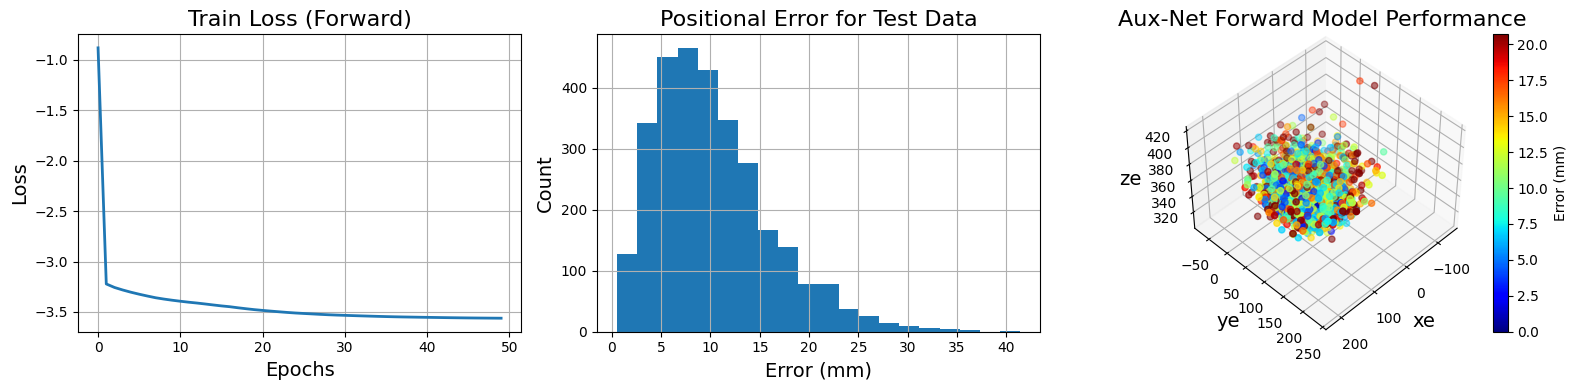

[aux_net] Inverse model succesfully loaded


In [5]:
from google.colab import drive

drive.mount('/gdrive')
drive_path = '/gdrive/My Drive/Github/aux-net'

# Generate trajectory from waypoints
interpolate_trajectory(drive_path + '/experiments/waypoints_E1.csv',drive_path+'/experiments/trajectory_E1.csv',0.002)

# Create bot and train
bot = aux_bot(drive_path = drive_path, data_path = "/data/15000_pose_data_07_26_2023.csv", train_forward=True, train_inverse=False, train_comp = False, normalize=True)

# Use inverse model for regression
#bot.inverse_prediction(input_path = drive_path+'/experiments/trajectory_E1.csv', output_path = drive_path+'/experiments/motor_trajectory_E1.csv')

In [ ]:
%cd '/gdrive/My Drive/Github/aux-net'
!git config --global user.email "kubekk101@gmail.com"
!git config --global user.name "KubaSrc"


/gdrive/My Drive/Github/aux-net


In [ ]:
!git push

Enumerating objects: 294, done.
Counting objects: 100% (294/294), done.
Delta compression using up to 2 threads
Compressing objects: 100% (288/288), done.
Writing objects: 100% (288/288), 1.01 GiB | 8.76 MiB/s, done.
Total 288 (delta 20), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (20/20), completed with 2 local objects.
To https://github.com/KubaSrc/aux-net.git
   f00d92c..15bec76  main -> main
